In [4]:
import pandas as pd
import os
import json
from shapely import wkt
from shapely.geometry import Polygon
from geopy.geocoders import Nominatim
from datetime import datetime
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Define location of the images and labels
xbd_dir="/content/drive/MyDrive/XBD/train/"
images_dir=os.path.join(xbd_dir,"images")
labels_dir=os.path.join(xbd_dir,"labels")
masks_dir = os.path.join(xbd_dir, 'masks')
if not os.path.isdir(masks_dir):
    os.makedirs(masks_dir)
train_data_info=os.path.join(xbd_dir,"train_data_info1.csv")

In [7]:
# Dont run if csv file is already created
#Create Dataframe
columns = ['pre_image_name', 'post_image_name', 'disaster_name', 'disaster_type',
           'disaster_location', 'num_buildings_pre', 'num_buildings_post',
           'num_no_damage', 'num_minor_damage', 'num_major_damage',
           'num_destroyed', 'num_un_classified','pre_disaster_capture_date','post_disaster_capture_date']
df = pd.DataFrame(columns=columns)
# Fetch values from json labels and enter into dataframe
# Dictionary to fill location for labels with missing buildings
disaster_location_info={}
# iterate through all labels files
for json_filename in tqdm(os.listdir(labels_dir)):
    # only process pre disaster json files
    if json_filename.endswith('.json') and "_pre" in json_filename:
        disaster_location=""
        # read json file
        pre_json_filepath=os.path.join(labels_dir,json_filename)
        # set post disaster json file name
        post_json_filepath = os.path.join(labels_dir, json_filename.replace("_pre", "_post"))
        # check if post disaster json file exists and skip considering current json file if post json doesn't exist
        if not os.path.exists(post_json_filepath):
            continue
        # read pre-disaster json
        with open(pre_json_filepath, 'r') as file:
            pre_data = json.load(file)
            # fetch pre-disaster image name from metadata
            pre_image_name=pre_data["metadata"]["img_name"]
            # fetch disaster event name from metadata
            disaster_name=pre_data["metadata"]["disaster"]
            # fetch disaster type from metadata
            disaster_type=pre_data["metadata"]["disaster_type"]
            # fetch pre-disaster image capture date from metadata
            pre_disaster_capture_date=datetime.fromisoformat(pre_data["metadata"]["capture_date"][:-1])
            pre_disaster_capture_date=pre_disaster_capture_date.date()
            # fetch lng_lat features from features
            lang_lat_features=pre_data["features"]["lng_lat"]
            # fetch number of buildings from features
            num_buildings_pre=len(pre_data["features"]["lng_lat"])
            # if any buildings exist in the image
            if num_buildings_pre>0:
                # get centroid of the location
                location_coords=lang_lat_features[0]["wkt"]
                centroid =  Polygon(wkt.loads(location_coords)).centroid
                # get location of the centroid
                geolocator = Nominatim(user_agent="geo_locator")
                location = geolocator.reverse((centroid.y, centroid.x))
                # get state/city and country from location
                if 'state' in location.raw['address']:
                    disaster_location = location.raw['address']['state'] + ", " + location.raw['address']['country']
                else:
                    disaster_location = location.raw['address']['city'] + ", " + location.raw['address']['country']
                disaster_location_info[disaster_name] = disaster_location
            # set disaster location to none if there are no buildings in the image
            else:
                disaster_location= None
        # read post-disaster json
        with open(post_json_filepath, 'r') as file:
            post_data = json.load(file)
            # fetch post-disaster image name from metadata
            post_image_name=post_data["metadata"]["img_name"]
            # fetch post-disaster image capture date from metadata
            post_disaster_capture_date=datetime.fromisoformat(post_data["metadata"]["capture_date"][:-1])
            post_disaster_capture_date=post_disaster_capture_date.date()
            # fetch building features from xy features
            building_features=post_data["features"]["xy"]
            # count number of buildings from features
            num_buildings_post=len(building_features)
            # count number of buildings by damage type
            building_damage_info={"no-damage":0,"minor-damage":0,"major-damage":0,"destroyed":0,"un-classified":0}
            for feature in building_features:
                damage_type=feature["properties"]["subtype"]
                building_damage_info[damage_type] += 1
            num_no_damage=building_damage_info["no-damage"]
            num_minor_damage=building_damage_info["minor-damage"]
            num_major_damage=building_damage_info["major-damage"]
            num_destroyed=building_damage_info["destroyed"]
            num_un_classified=building_damage_info["un-classified"]
        # create dataframe row
        row_data = {
            "pre_image_name": pre_image_name,
            "post_image_name": post_image_name,
            "disaster_name": disaster_name,
            "disaster_type": disaster_type,
            "disaster_location": disaster_location,
            "num_buildings_pre": num_buildings_pre,
            "num_buildings_post": num_buildings_post,
            "num_no_damage": num_no_damage,
            "num_minor_damage": num_minor_damage,
            "num_major_damage": num_major_damage,
            "num_destroyed": num_destroyed,
            "num_un_classified": num_un_classified,
            "pre_disaster_capture_date": pre_disaster_capture_date,
            "post_disaster_capture_date": post_disaster_capture_date
        }
        # append row to dataframe
        df=pd.concat([df, pd.DataFrame([row_data])], ignore_index=True)

100%|██████████| 1866/1866 [06:56<00:00,  4.48it/s]


In [8]:
#if any disaster location is null fill it with info from disaster_location_info
#run only if csv is not created
df.loc[df["disaster_location"].isnull(), "disaster_location"] = df["disaster_name"].map(disaster_location_info)

In [9]:
df["pre_disaster_capture_date"][0],df["post_disaster_capture_date"][0]

(datetime.date(2019, 1, 26), datetime.date(2019, 5, 31))

In [10]:
unique_dates = df.groupby('disaster_name')[['pre_disaster_capture_date', 'post_disaster_capture_date']].agg(pd.Series.unique)
unique_dates

,pre_disaster_capture_date,post_disaster_capture_date
disaster_name,,
guatemala-volcano,[2018-02-05],[2018-06-22]
hurricane-florence,"[2018-08-23, 2018-04-06]","[2018-09-18, 2018-09-20]"
hurricane-harvey,[2017-02-16],[2017-08-31]
hurricane-matthew,"[2013-01-05, 2013-06-09]","[2016-10-01, 2016-10-09, 2016-10-10, 2016-10-0..."
hurricane-michael,"[2017-11-29, 2017-10-05]",[2018-10-13]
mexico-earthquake,"[2017-01-04, 2017-06-15]",[2017-09-20]
midwest-flooding,[2019-01-26],"[2019-05-31, 2019-05-30]"
palu-tsunami,"[2017-01-24, 2018-02-20, 2016-10-25, 2017-07-12]",[2018-10-01]
santa-rosa-wildfire,"[2017-06-21, 2017-05-21]",[2017-10-11]


In [30]:
df_capture_dates = df.groupby('disaster_name').agg({'pre_disaster_capture_date': lambda x: x.mode()[0], 'post_disaster_capture_date': lambda x: x.mode()[0]}).reset_index()
df_capture_dates['diff_in_years'] = ((df_capture_dates['post_disaster_capture_date'] - df_capture_dates['pre_disaster_capture_date']).dt.days / 365).round(1)
df_capture_dates

,disaster_name,pre_disaster_capture_date,post_disaster_capture_date,diff_in_years
0,guatemala-volcano,2018-02-05,2018-06-22,0.4
1,hurricane-florence,2018-04-06,2018-09-20,0.5
2,hurricane-harvey,2017-02-16,2017-08-31,0.5
3,hurricane-matthew,2013-06-09,2016-10-10,3.3
4,hurricane-michael,2017-11-29,2018-10-13,0.9
5,mexico-earthquake,2017-01-04,2017-09-20,0.7
6,midwest-flooding,2019-01-26,2019-05-30,0.3
7,palu-tsunami,2017-01-24,2018-10-01,1.7
8,santa-rosa-wildfire,2017-06-21,2017-10-11,0.3
9,socal-fire,2018-10-23,2018-11-14,0.1


In [14]:
# save the dataframe to csv
# run only first time
df.to_csv(train_data_info, index=False)

In [ ]:
# load the csv file if already created
df = pd.read_csv(train_data_info)

In [17]:
df["post_disaster_capture_date"].value_counts()

post_disaster_capture_date
2018-10-23    307
2017-02-16    108
2018-04-06    102
2019-01-26     80
2017-11-29     72
2013-06-09     52
2017-06-21     45
2017-01-04     32
2017-05-21     29
2017-01-24     27
2017-10-05     26
2013-01-05     21
2018-02-20      8
2018-08-23      6
2016-10-25      6
2017-06-15      6
2018-02-05      5
2017-07-12      1
Name: count, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 933 entries, 0 to 932
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   pre_image_name              933 non-null    object
 1   post_image_name             933 non-null    object
 2   disaster_name               933 non-null    object
 3   disaster_type               933 non-null    object
 4   disaster_location           933 non-null    object
 5   num_buildings_pre           933 non-null    object
 6   num_buildings_post          933 non-null    object
 7   num_no_damage               933 non-null    object
 8   num_minor_damage            933 non-null    object
 9   num_major_damage            933 non-null    object
 10  num_destroyed               933 non-null    object
 11  num_un_classified           933 non-null    object
 12  pre_disaster_capture_date   933 non-null    object
 13  post_disaster_capture_date  933 non-null    object

In [ ]:
# fetch all disaster events in the df
df["disaster_name"].unique()

array(['midwest-flooding', 'palu-tsunami', 'santa-rosa-wildfire',
       'socal-fire', 'guatemala-volcano', 'hurricane-florence',
       'hurricane-harvey', 'hurricane-matthew', 'hurricane-michael',
       'mexico-earthquake'], dtype=object)

In [ ]:
#check if there are any null values
df.isnull().any()

pre_image_name        False
post_image_name       False
disaster_name         False
disaster_type         False
disaster_location     False
num_buildings_pre     False
num_buildings_post    False
num_no_damage         False
num_minor_damage      False
num_major_damage      False
num_destroyed         False
num_un_classified     False
dtype: bool

In [ ]:
df.head()

,pre_image_name,post_image_name,disaster_name,disaster_type,disaster_location,num_buildings_pre,num_buildings_post,num_no_damage,num_minor_damage,num_major_damage,num_destroyed,num_un_classified
0,midwest-flooding_00000071_pre_disaster.png,midwest-flooding_00000071_post_disaster.png,midwest-flooding,flooding,"Arkansas, United States",186,186,159,1,0,0,26
1,midwest-flooding_00000072_pre_disaster.png,midwest-flooding_00000072_post_disaster.png,midwest-flooding,flooding,"Arkansas, United States",198,198,198,0,0,0,0
2,midwest-flooding_00000006_pre_disaster.png,midwest-flooding_00000006_post_disaster.png,midwest-flooding,flooding,"Arkansas, United States",5,5,1,0,0,4,0
3,midwest-flooding_00000128_pre_disaster.png,midwest-flooding_00000128_post_disaster.png,midwest-flooding,flooding,"Oklahoma, United States",9,9,8,0,0,1,0
4,midwest-flooding_00000105_pre_disaster.png,midwest-flooding_00000105_post_disaster.png,midwest-flooding,flooding,"Arkansas, United States",0,0,0,0,0,0,0


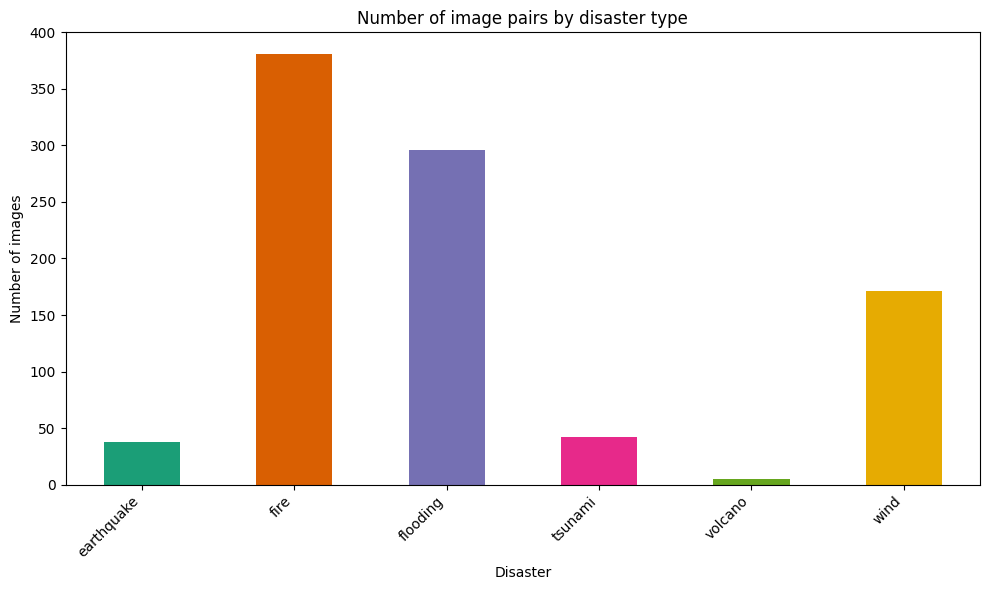

In [ ]:
# plot number of image pairs per disaster type
plt.figure(figsize=(10, 6))
df.groupby('disaster_type').size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.title('Number of image pairs by disaster type')
plt.xlabel('Disaster')
plt.ylabel('Number of images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# check if any columns have different number of buildings pre and post disaster
df[df['num_buildings_pre'] != df['num_buildings_post']]

,pre_image_name,post_image_name,disaster_name,disaster_type,disaster_location,num_buildings_pre,num_buildings_post,num_no_damage,num_minor_damage,num_major_damage,num_destroyed,num_un_classified


In [ ]:
# Disaster event name along with disaster location and disaster type
df.groupby('disaster_name')[['disaster_location','disaster_type']].first()

,disaster_location,disaster_type
disaster_name,,
guatemala-volcano,"Sacatepéquez, Guatemala",volcano
hurricane-florence,"South Carolina, United States",flooding
hurricane-harvey,"Texas, United States",flooding
hurricane-matthew,"Département du Sud, Ayiti",wind
hurricane-michael,"Florida, United States",wind
mexico-earthquake,"Ciudad de México, México",earthquake
midwest-flooding,"Arkansas, United States",flooding
palu-tsunami,"Sulawesi Tengah, Indonesia",tsunami
santa-rosa-wildfire,"California, United States",fire


In [ ]:
# Number of image pairs per disaster event
num_images_by_disaster=df["disaster_name"].value_counts()
num_images_by_disaster

disaster_name
socal-fire             307
hurricane-florence     108
hurricane-harvey       108
hurricane-michael       98
midwest-flooding        80
santa-rosa-wildfire     74
hurricane-matthew       73
palu-tsunami            42
mexico-earthquake       38
guatemala-volcano        5
Name: count, dtype: int64

In [ ]:
# number of buildings from all image pairs per disaster event
num_buildings_by_disaster=df.groupby('disaster_name')['num_buildings_pre'].sum()
num_buildings_by_disaster

disaster_name
guatemala-volcano         32
hurricane-florence      2268
hurricane-harvey        7715
hurricane-matthew       4189
hurricane-michael       5657
mexico-earthquake      11411
midwest-flooding        2532
palu-tsunami           12560
santa-rosa-wildfire     4226
socal-fire              4272
Name: num_buildings_pre, dtype: int64

In [ ]:
# number of images and buildings per disaster event
combined_table = pd.concat([num_images_by_disaster, num_buildings_by_disaster], axis=1)
combined_table.columns = ['Num_Images', 'Num_Buildings']
combined_table

,Num_Images,Num_Buildings
disaster_name,,
socal-fire,307,4272
hurricane-florence,108,2268
hurricane-harvey,108,7715
hurricane-michael,98,5657
midwest-flooding,80,2532
santa-rosa-wildfire,74,4226
hurricane-matthew,73,4189
palu-tsunami,42,12560
mexico-earthquake,38,11411


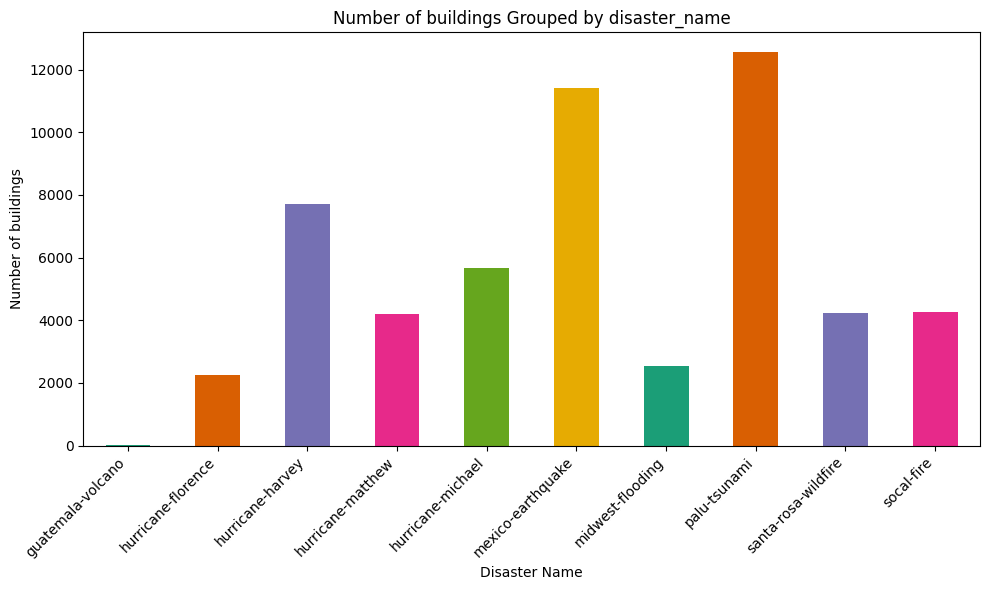

In [ ]:
# plot number of buildings per disaster event
plt.figure(figsize=(10, 6))
num_buildings_by_disaster.plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.title('Number of buildings Grouped by disaster_name')
plt.xlabel('Disaster Name')
plt.ylabel('Number of buildings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

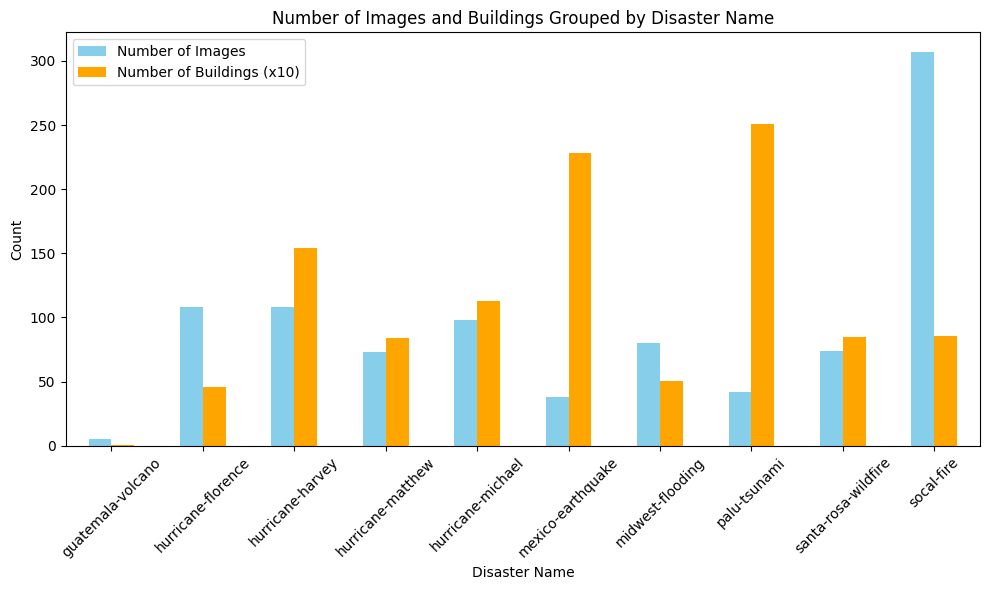

In [ ]:
# plot number of buildings and images comparision
combined_data = pd.DataFrame({"Number of Images": num_images_by_disaster,
                              "Number of Buildings": num_buildings_by_disaster})

ax = combined_data.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'])
ax.set_title('Number of Images and Buildings Grouped by Disaster Name')
ax.set_xlabel('Disaster Name')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
damage_counts_by_disaster = df.groupby("disaster_name")[["num_no_damage", "num_minor_damage", "num_major_damage", "num_destroyed"]].sum()
damage_counts_by_disaster

,num_no_damage,num_minor_damage,num_major_damage,num_destroyed
disaster_name,,,,
guatemala-volcano,26,3,0,1
hurricane-florence,1676,50,381,10
hurricane-harvey,4168,871,2374,196
hurricane-matthew,617,2339,336,679
hurricane-michael,3647,1363,409,183
mexico-earthquake,11284,84,31,1
midwest-flooding,2277,41,25,48
palu-tsunami,10927,0,250,1237
santa-rosa-wildfire,3222,19,9,964


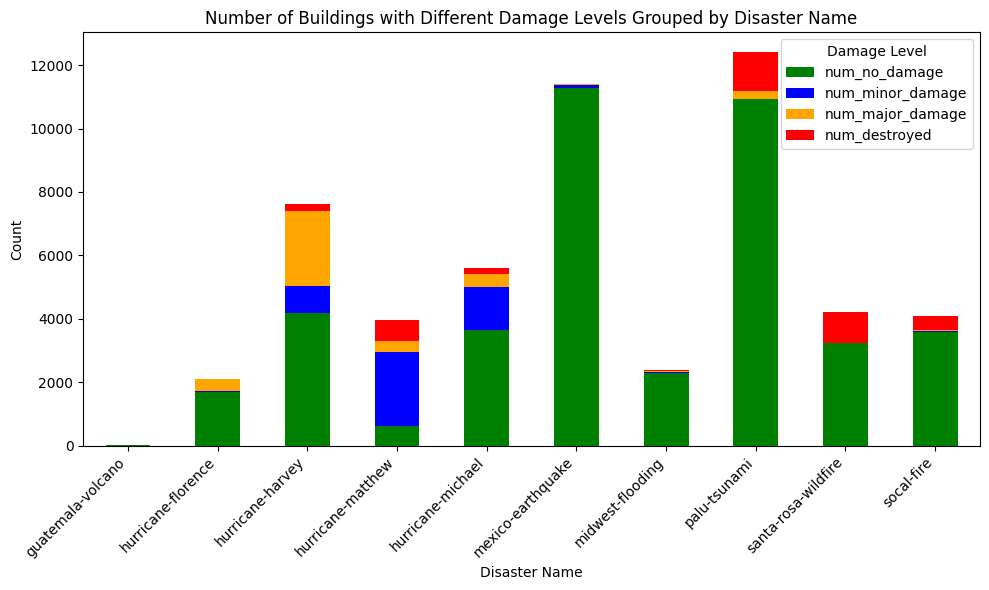

In [ ]:
custom_colors = ['green', 'blue', 'orange', 'red']
damage_counts_by_disaster.plot(kind='bar', stacked=True, figsize=(10, 6), color=custom_colors)
plt.title('Number of Buildings with Different Damage Levels Grouped by Disaster Name')
plt.xlabel('Disaster Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Damage Level')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
disaster_names=list(df["disaster_name"].unique())
disaster_names

['socal-fire',
 'hurricane-michael',
 'palu-tsunami',
 'hurricane-florence',
 'midwest-flooding',
 'hurricane-matthew',
 'hurricane-harvey',
 'santa-rosa-wildfire',
 'mexico-earthquake',
 'guatemala-volcano']

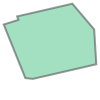

In [ ]:
temp1=wkt.loads("POLYGON ((-79.03585510827186 33.60387497715141, -79.03582104187559 33.60388575665863, -79.03582375650119 33.60389388588764, -79.03569553047664 33.60392338512618, -79.03564470548032 33.60386354920797, -79.03563977720466 33.6037826097889, -79.03578743284996 33.6037485675312, -79.03580478400323 33.60375046033562, -79.03585510827186 33.60387497715141))")
temp1

In [ ]:
temp2 = list(mapping(temp1)['coordinates'][0])
temp3 = np.array(temp2, np.int32)
temp2,temp3

([(-79.03585510827186, 33.60387497715141),
  (-79.0358210418756, 33.60388575665863),
  (-79.03582375650119, 33.60389388588764),
  (-79.03569553047664, 33.60392338512618),
  (-79.03564470548032, 33.60386354920797),
  (-79.03563977720466, 33.6037826097889),
  (-79.03578743284996, 33.6037485675312),
  (-79.03580478400323, 33.60375046033562),
  (-79.03585510827186, 33.60387497715141)],
 array([[-79,  33],
        [-79,  33],
        [-79,  33],
        [-79,  33],
        [-79,  33],
        [-79,  33],
        [-79,  33],
        [-79,  33],
        [-79,  33]], dtype=int32))

In [ ]:
import cv2
import numpy as np
from shapely import wkt
from shapely.geometry import mapping, Polygon
from skimage.io import imread

# Create the Polygon Mask files using the labels
# takes mask size(height and width) and polygon vertices
def generate_polygon_masks(mask_size, polys):
    # shrink the polygon vertices by 2 pixels
    shrink=2
    # initialize mask array and fill with 0
    mask = np.zeros(mask_size, np.uint8)
    # iterate over all building polygons in the image
    for i in polys:
        # get the polygon vertices
        poly = polys[i]
        # create shapely polygon object for the building
        polygon = Polygon(poly)
        # calculate centroid of the polygon
        (centroid_x, centroid_y) = polygon.centroid.coords[0]
        shrunk_polygon = []
        # iterate over the exterior coordinates
        for (x,y) in polygon.exterior.coords:
            # shrink the polygon by 2 pixels on all sides
            x += shrink if x < centroid_x else -shrink if x > centroid_x else 0
            y += shrink if y < centroid_y else -shrink if y > centroid_y else 0
            shrunk_polygon.append([x,y])
        temp=np.zeros(mask_size, np.uint8)
        # fill the polygon area with white color
        cv2.fillPoly(temp, [np.array(shrunk_polygon, np.int32)], (1, 1, 1))
        mask += temp
    # convert the mask to binary where white pixels represent the polygon areas.
    mask[mask > 1] = 0
    mask[mask == 1] = 255
    return mask

In [ ]:
pre_image_names=[]
# Create the full path to the images, labels, and mask output directories
print(f"Starting Mask Generation")
print(f"Source Image Directory: {images_dir} \nSource JSON Directory: {labels_dir}\nOutput Directory: {masks_dir}")
#Get the list of pre-disaster json files
labels_pre = []
for file_name in os.listdir(labels_dir):
    # consider only pre disaster labels
    if '_pre' in file_name:
        labels_pre.append(file_name)
img_count=0
label_count=0
mask_count=0
images_without_buildings_count=0
# generate masks using pre disaster labels
for label_file in labels_pre:
    # Configure source image and generated mask names and paths
    image_name = os.path.splitext(label_file)[0] + '.png'
    pre_image_names.append(image_name)
    mask_file_name = image_name
    label_full_path = os.path.join(labels_dir, label_file)
    # Read Data From label JSON file
    mask_json = json.load(open(label_full_path))
    label_count+=1
    # Read Image File
    image_file = os.path.join(images_dir, image_name)
    img = cv2.imread(image_file)
    img = np.array(img)
    # mask size is same as image size
    mask_size = img.shape
    img_count+=1
    # Read Building Features from Json
    polys = {}
    for feature in mask_json['features']['xy']:
        # extract building shape in wkt format from json and convert to shapely object
        building_shape = wkt.loads(feature['wkt'])
        # extract building vertices/co-ordinates from shapely object
        coords = list(mapping(building_shape)['coordinates'][0])
        # store co-ordinates to polys dictionary with building id as key
        polys[feature['properties']['uid']] = (np.array(coords, np.int32))
    # check if there are any buildings in the image
    if len(polys) > 0:
        # generate mask using polygon vertices
        masked_polys = generate_polygon_masks(mask_size, polys)
        # configure mask file path
        mask_file_path = os.path.join(masks_dir, mask_file_name)
        # save mask image
        cv2.imwrite(mask_file_path, masked_polys)
        mask_count+=1
    else:
        images_without_buildings_count+=1
print("Images checked: ",img_count)
print("Labels checked: ",label_count)
print("Masks Generated: ",mask_count)
print("Images Without Buildings: ",images_without_buildings_count)
print("Mask Generation Complete")

Starting Mask Generation
Source Image Directory: /Users/yugandarnarra/Downloads/Project/test/images 
Source JSON Directory: /Users/yugandarnarra/Downloads/Project/test/labels
Output Directory: /Users/yugandarnarra/Downloads/Project/test/masks
Images checked:  933
Labels checked:  933
Masks Generated:  752
Images Without Buildings:  181
Mask Generation Complete


In [ ]:
from sklearn.model_selection import train_test_split
#Split data into train and test
mask_image_names=os.listdir(masks_dir)
train_set, test_set = train_test_split(pre_image_names, test_size=0.25, random_state=42)
# save train image names to train.txt and test to test.txt
train_file_path=os.path.join(xbd_dir,"train.txt")
test_file_path=os.path.join(xbd_dir,"test.txt")

# Write the train set to train.txt
with open(train_file_path, "w") as train_file:
    train_file.write("\n".join(train_set))

# Write the test set to test.txt
with open(test_file_path, "w") as test_file:
    test_file.write("\n".join(test_set))

In [ ]:
from PIL import Image
# Generate mean.npy for Localization Model
mean_file=os.path.join(xbd_dir,"mean.npy")

N = len(pre_image_names)
sum_color = np.zeros((3,))

# Compute mean image
for i, image_name in enumerate(mask_image_names):
    with Image.open(os.path.join(images_dir, image_name)) as image_file:
        image = np.asarray(image_file, dtype=np.float64)
    sum_color += np.mean(image, axis=(0, 1))

mean = sum_color / N

# Save mean in npy format
np.save(mean_file, mean)